# A MadMiner Example Analysis -  Analyzing dim6 operators in $W\gamma$ 

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)


This tutorial does not try to explain the inference methods. To understand what MadMiner is doing, please have a look at some papers first: 
- J. Brehmer, K. Cranmer, G. Louppe, J. Pavez: ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) explains the basic idea of most of the methods presented here
- J. Brehmer, K. Cranmer, G. Louppe, J. Pavez: ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) is an extensive 65-page handbook going through the details

# Part 1: Setup and Event Generation

## Preparations

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes. Note that at least for now, the MG-Pythia interface and Delphes require custom patches (available upon request). In addition, MadMiner has to be in your PYTHONPATH.

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5. 

**This needs to be updated by the user**

In [3]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 1. Setup

### 1a) Define parameter space

After creating a `MadMiner` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in $1/\Lambda$) is not taken into account, in which case `morphing_max_power=1`. The `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

Finally, the parameter values theta used internally by MadMiner and the parameter values written to the param_card (or reweight_card) given to MadGraph do not have to be exactly the same. With the option `parm_card_transform`, the user can supply a one-parameter function that maps a parameter value theta to the value given to MadGraph. This string is a python expression, in which `theta` is parsed as the parameter value. For instance, if the internal parameters are in the range (0, 1), but should be linearly scaled to (0, 100) in the param_card, one would have to use `param_card_transform="100*theta"`.

In [4]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)

22:18  
22:18  ------------------------------------------------------------
22:18  |                                                          |
22:18  |  MadMiner v0.1.0                                         |
22:18  |                                                          |
22:18  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
22:18  |                                                          |
22:18  ------------------------------------------------------------
22:18  
22:18  Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:18  Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))


### 1b) Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

One can define benchmarks by hand:

In [5]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':20., 'CPWL2':0.},
    'w'
)

22:18  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
22:18  Added benchmark w: CWL2 = 20.00, CPWL2 = 0.00e+00)


If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points. The argument `n_trials` determines the number of random candidate bases that the optimization algorithm goes through.

In [6]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

22:18  Optimizing basis for morphing
22:18  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
22:18  Added benchmark w: CWL2 = 20.00, CPWL2 = 0.00e+00)
22:18  Added benchmark morphing_basis_vector_2: CWL2 = -5.87e+00, CPWL2 = 49.22)
22:18  Added benchmark morphing_basis_vector_3: CWL2 = 41.02, CPWL2 = -4.58e+01)
22:18  Added benchmark morphing_basis_vector_4: CWL2 = -4.94e+01, CPWL2 = -1.93e+01)
22:18  Added benchmark morphing_basis_vector_5: CWL2 = -3.29e+01, CPWL2 = -4.56e+01)


Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

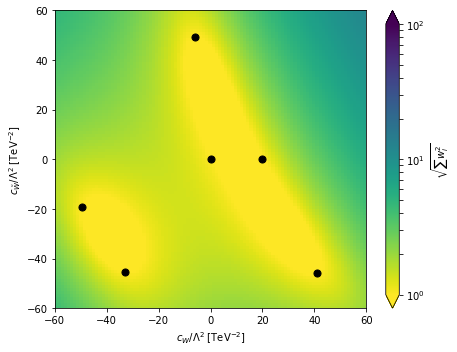

In [7]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-60.,60),
    yrange=(-60.,60.)
)

### 1c) Save setup

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [8]:
miner.save('data/madminer_example.h5')

22:19  Saving setup (including morphing) to data/madminer_example.h5


They can now be loaded again with `miner.load(filename)`.

## 2. Event Generation

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You have to provide paths to the process card, run card and param card (the entries corresponding to the parameters of interest will be automatically adapted). Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first.

Finally, if MadGraph is supposed to run in a different Python environment or requires other setup steps, you can use the `initial_command` argument. If your default Python environment is Python 2.7, you do not have to use this. If it is Python 3.x, you should use this to activate a Python 2 environment (see [the conda documentation](https://conda.io/docs/user-guide/tasks/manage-environments.html)). Here we assume you have create a conda environment `python2` for this purpose. 

**The `initial_command` line typicially has to be updated by the user**

In [9]:
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/wgamma',
    proc_card_file='cards/proc_card_wgamma.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_wgamma.dat',
    log_directory='logs/wgamma',
    initial_command='source ~/.bashrc'
)

22:19  Generating MadGraph process folder from cards/proc_card_wgamma.dat at ./mg_processes/wgamma
22:19  Run 0
22:19    Sampling from benchmark: sm
22:19    Original run card:       cards/run_card_wgamma.dat
22:19    Original Pythia8 card:   None
22:19    Copied run card:         /madminer/cards/run_card_0.dat
22:19    Copied Pythia8 card:     None
22:19    Param card:              /madminer/cards/param_card_0.dat
22:19    Reweight card:           /madminer/cards/reweight_card_0.dat
22:19    Log file:                run_0.log
22:19  Creating param and reweight cards in ./mg_processes/wgamma//madminer/cards/param_card_0.dat, ./mg_processes/wgamma//madminer/cards/reweight_card_0.dat
22:19  Starting MadGraph and Pythia in ./mg_processes/wgamma


## 3. Extract Parton Level Observables / Weights 

### 3a) Setting up the LHEProcessor

Here we extract the parton level information (observables and weights) from the .lhe file. This is done with the LHEProcessor package. 

In [10]:
lhep = LHEProcessor()

After creating the object, one can add a number of LHE event samples.

In [11]:
lhep.add_lhe_sample('mg_processes/wgamma/Events/run_01/unweighted_events.lhe.gz',sampling_benchmark="sm")

22:31  Adding LHE sample at mg_processes/wgamma/Events/run_01/unweighted_events.lhe.gz


We also want to specify the Benchmark names, because sometimes the order is mixed up in the LHE files. But fortunately, we already stored them in the HDF5 file. 

In [12]:
lhep.read_benchmark_names('data/madminer_example.h5')

### 3b) Defining observables

We can now process the data and evaluate observables for each event. This is needed for example for plotting or to evaluate the Fisher Information in histograms of observables. 

Observables are also used for the MadMiner Machine Learning approach. Note that this requires a complete set of obseravbles that can encode the full kinematics of the event. Additionally, we have found that the Machine Learning performs better higher level observables (such as masses or angular differences between particles) than with the four momenta itself (pz, py, pz, E).

Observables can be any function of the fpr momenta. The `p[i]` correspond to the i'th parton momentum as specified when generating the process.  All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

In [13]:
lhep.add_observable('px_l', 'p[0].px')
lhep.add_observable('px_v', 'p[1].px')
lhep.add_observable('px_a', 'p[2].px')

lhep.add_observable('py_l', 'p[0].py')
lhep.add_observable('py_v', 'p[1].py')
lhep.add_observable('py_a', 'p[2].py')

lhep.add_observable('pz_l', 'p[0].pz')
lhep.add_observable('pz_v', 'p[1].pz')
lhep.add_observable('pz_a', 'p[2].pz')

lhep.add_observable('e_l', 'p[0].e')
lhep.add_observable('e_v', 'p[1].e')
lhep.add_observable('e_a', 'p[2].e')

lhep.add_observable('pt_l', 'p[0].pt')
lhep.add_observable('pt_v', 'p[1].pt')
lhep.add_observable('pt_a', 'p[2].pt')

lhep.add_observable('eta_l', 'p[0].eta')
lhep.add_observable('eta_v', 'p[1].eta')
lhep.add_observable('eta_a', 'p[2].eta')

lhep.add_observable('dphi_lv', 'p[0].deltaphi(p[1])')
lhep.add_observable('dphi_la', 'p[0].deltaphi(p[2])')
lhep.add_observable('dphi_va', 'p[1].deltaphi(p[2])')

lhep.add_observable('m_lv' , '(p[0] + p[1]).m')
lhep.add_observable('m_lva', '(p[0] + p[1] + p[2]).m')

22:31  Adding (not required) observable px_l = p[0].px
22:31  Adding (not required) observable px_v = p[1].px
22:31  Adding (not required) observable px_a = p[2].px
22:31  Adding (not required) observable py_l = p[0].py
22:31  Adding (not required) observable py_v = p[1].py
22:31  Adding (not required) observable py_a = p[2].py
22:31  Adding (not required) observable pz_l = p[0].pz
22:31  Adding (not required) observable pz_v = p[1].pz
22:31  Adding (not required) observable pz_a = p[2].pz
22:31  Adding (not required) observable e_l = p[0].e
22:31  Adding (not required) observable e_v = p[1].e
22:31  Adding (not required) observable e_a = p[2].e
22:31  Adding (not required) observable pt_l = p[0].pt
22:31  Adding (not required) observable pt_v = p[1].pt
22:31  Adding (not required) observable pt_a = p[2].pt
22:31  Adding (not required) observable eta_l = p[0].eta
22:31  Adding (not required) observable eta_v = p[1].eta
22:31  Adding (not required) observable eta_a = p[2].eta
22:31  Add

### 3c) Run LHEProcessor

The function `analyse_lhe_samples` extracts all these observables and weights from the LHE file(s) 

In [14]:
lhep.analyse_lhe_samples()

22:31  Analysing LHE sample mg_processes/wgamma/Events/run_01/unweighted_events.lhe.gz


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [15]:
lhep.save('data/madminer_example_with_lhedata.h5', 'data/madminer_example.h5')

22:32  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_example_with_lhedata.h5


Let's make a quick cross check by plotting a distributions (Warning: plot's don't look very pretty)

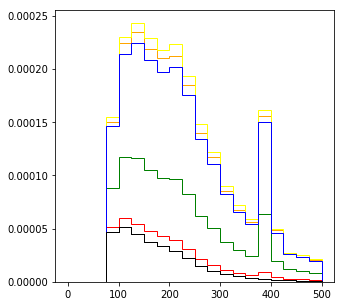

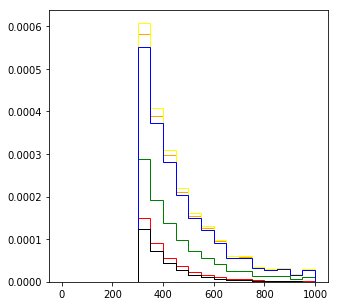

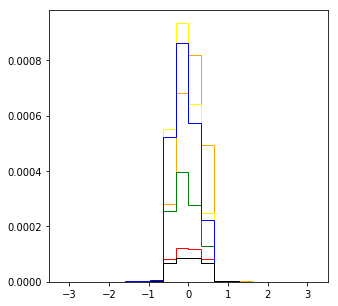

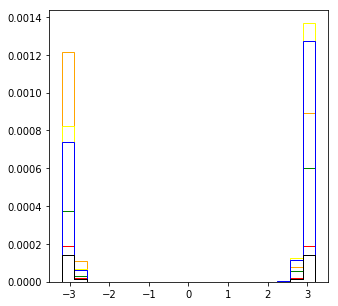

In [16]:
mycolors=["black","red","orange","yellow","green","blue","purple"]

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['pt_v'], range=(0.,500.), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['pt_v'], range=(0.,500.), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['pt_a'], range=(0.,1000.), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['pt_a'], range=(0.,1000.), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['dphi_lv'], range=(-3.2,3.2), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['dphi_lv'], range=(-3.2,3.2), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['dphi_la'], range=(-3.2,3.2), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['dphi_la'], range=(-3.2,3.2), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

### 3e) Combining Samples (if necessary) 

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In our case we only have one sample, so this is not strictly necessary, but we still include it for completeness.

In [17]:
combine_and_shuffle(
    ['data/madminer_example_with_lhedata.h5'],
    'data/madminer_example_shuffled.h5'
)

22:32  Copying setup from data/madminer_example_with_lhedata.h5 to data/madminer_example_shuffled.h5
22:32  Loading samples from file 1 / 1 at data/madminer_example_with_lhedata.h5
